<a href="https://colab.research.google.com/github/geekyJock8/Whats-your-number/blob/master/What's_your_number.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What's your number?

This is the first assignment of the fastai course. You can find details about the course <a href='https://course.fast.ai/index.html'>here</a>.

*Before we start using fastai, we need to install the necessary packages. You can skip this if you fastai is already configured on your setup.*

In [6]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


Every notebook starts with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1](http://www.fast.ai/2018/10/02/fastai-ai/) library which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163).

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

# Processing Data
We are going to use [MNIST](https://en.wikipedia.org/wiki/MNIST_database) database for this.

In [9]:
path = untar_data(URLs.MNIST)
path

PosixPath('/root/.fastai/data/mnist_png')

In [10]:
path.ls()

[PosixPath('/root/.fastai/data/mnist_png/training'),
 PosixPath('/root/.fastai/data/mnist_png/testing')]

In [0]:
train_data = path/'training'
test_data = path/'testing'

Here, we see that the data is sorted in folder format. We have two folders 'training' and 'testing' data. Inside both these folders, we have 10 folder named 0,1,2,3...,9,10, with each folder representing the images of the corresponding number.

*Let's quickly see the docs to see how to handle such kind of data.*

In [12]:
doc(ImageDataBunch.from_folder)

In [13]:
doc(get_transforms)

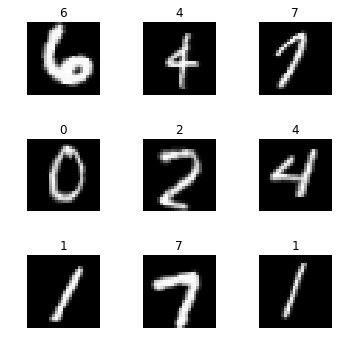

In [14]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, train='training', valid='testing', ds_tfms=tfms, size=26)

data.show_batch(rows=3, figsize=(5,5))

Here we can see a sample data. Let's quickly check out all the different classes(there should be 10 classes from '0' to '10') to see if everything's right or not.

In [15]:
print(data.classes)
len(data.classes),data.c

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


(10, 10)

# Training Data

We will train our data on [ResNet34](https://neurohive.io/en/popular-networks/resnet/). Let's load our model.

In [16]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 70144024.04it/s]


In [17]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [18]:
doc(learn.fit_one_cycle)

Using **fit_one_cycle**, we will train our model for 4 epochs. We could have choosen to train our model one by one but it's probably better and more time effcient to run it small batches. Feel free to experiment.

In [19]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.580219,0.310772,0.096300,01:31
1,0.240037,0.105877,0.035100,01:31
2,0.170642,0.073526,0.024100,01:31
3,0.152413,0.066327,0.022000,01:31


We see that after 4 epochs we have an error rate of 2.2% which seems pretty good. And it took only about one and half minute. *Let's save our model right now*. We will check the accuracy of our model next.



In [0]:
learn.save('fit_one_cycle-4-epochs')

# Checking Accuracy

In [22]:
interp = ClassificationInterpretation.from_learner(learn)

losses, idxs = interp.top_losses()

len(data.valid_ds) == len(losses) == len(idxs)

True


We use this to check the validity of the data.
```
len(data.valid_ds) == len(losses) == len(idxs)
```

Let's plot our top losses and see what's happening:


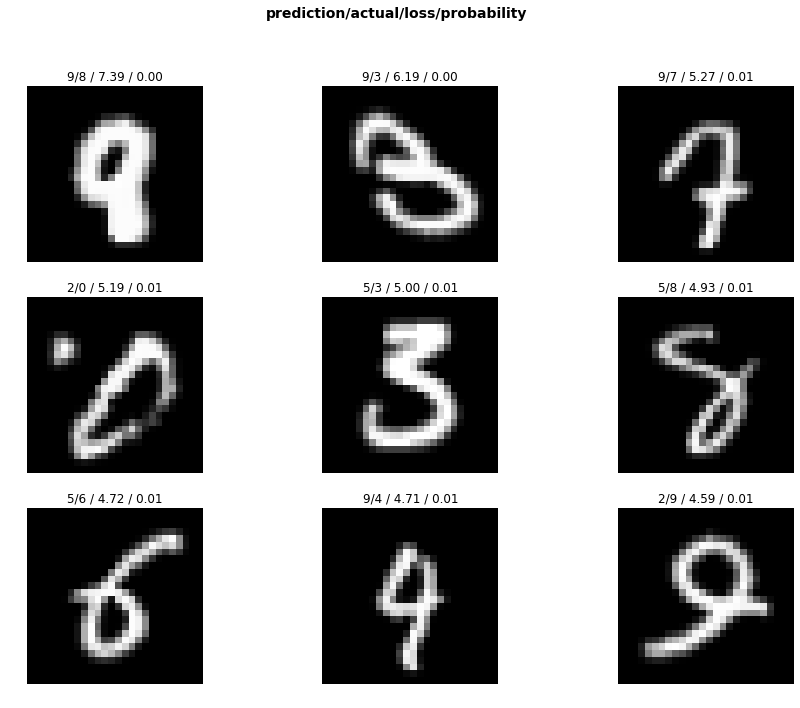

In [25]:
interp.plot_top_losses(9, figsize=(15,11))

Here we can see that some results make sense and some doesn't. 
Let check out some results 


*   **[0,0] (9/8/7.39/0.00)** - We can see that how it looks like 9. Even I probably would have said 9 but the worrying thing is that, it had a 0% chance of predicting a 8.
*   **[1,0] (2/0/5.19/0.01)** - In this case the dot at top left adds some noise but it difficult to make sense as to why it would predict a 2.
*   **[2,0] (5/6/4.72/0.01)** - In this case we can see that the 6 had some features of 5 like the horizontal dash at the top, Bottom curve of 5, tilted vertical connecting top and bottom parts. But again the problem is that, it had such a low percentage for 6.
*   **[2,2] (2/9/4.59/0.01)** - In this case again we can see the curve of two but apart from that it mostly looks like a 9.

So, from this we can infer that it is recognising curves pretty well but it's having a little difficult when a curve makes a **loop.**



In [26]:
doc(interp.plot_top_losses)

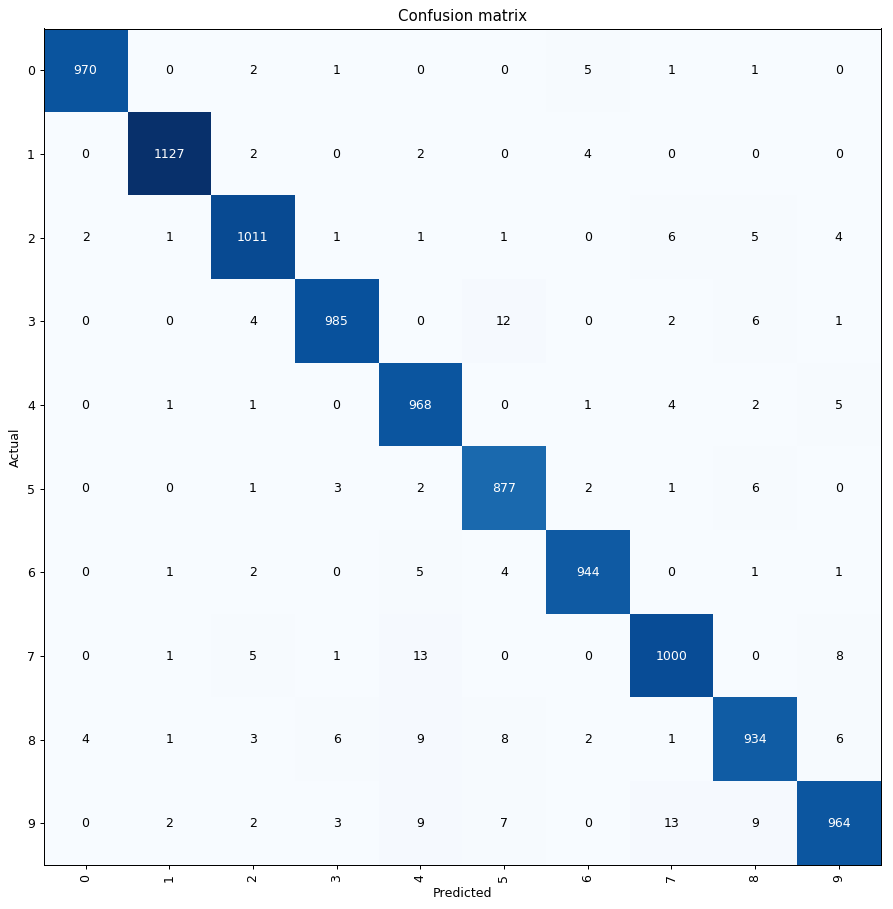

In [30]:
interp.plot_confusion_matrix(figsize=(10,10), dpi=90)

From confusion matrix we can see that our earlier inference is making more sense. The numbers which have no loops(1,2,7) performed the best. But overall our model is doing quite well as we can see that most of the values are across the diagonal.


Let's check out the most confused values. As they say **Once may be a mistake, twice maybe a lapse but three times is a choice**. We will filter out all the values which were wrong atleast 3 times.

In [33]:
interp.most_confused(min_val=3)

[('7', '4', 13),
 ('9', '7', 13),
 ('3', '5', 12),
 ('8', '4', 9),
 ('9', '4', 9),
 ('9', '8', 9),
 ('7', '9', 8),
 ('8', '5', 8),
 ('9', '5', 7),
 ('2', '7', 6),
 ('3', '8', 6),
 ('5', '8', 6),
 ('8', '3', 6),
 ('8', '9', 6),
 ('0', '6', 5),
 ('2', '8', 5),
 ('4', '9', 5),
 ('6', '4', 5),
 ('7', '2', 5),
 ('1', '6', 4),
 ('2', '9', 4),
 ('3', '2', 4),
 ('4', '7', 4),
 ('6', '5', 4),
 ('8', '0', 4),
 ('5', '3', 3),
 ('8', '2', 3),
 ('9', '3', 3)]

Although our model had low error rate(2.2%), there are still a lot of values which are being predicted incorrectly. And it's probably due to the loops. **So, we will unfreeze our entire model and allow all the layers to trained.** As loop detection feature is probably present in one of the earlier layers.

# Training some more

In [35]:
doc(learn.unfreeze)

In [0]:
learn.unfreeze()

In [36]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.048266,0.018508,0.005400,01:39


We can see that just after one epoch, we get better results. Actually unbelievable results with error of 0.54%.

Is it overfitting? It's possible!

Let's check out the **new results.**

In [37]:
interp = ClassificationInterpretation.from_learner(learn)

losses, idxs = interp.top_losses()

len(data.valid_ds) == len(losses) == len(idxs)

True

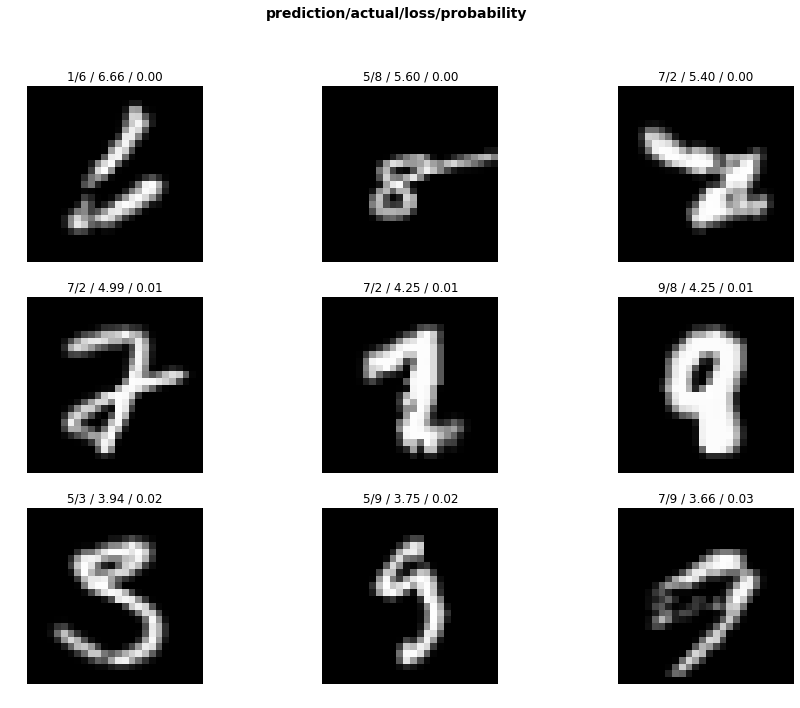

In [38]:
interp.plot_top_losses(9, figsize=(15,11))

We see that one of our eariler case, repears([1,2] 9/8/4.25/0.01). But these numbers are definitely far more blurred and difficult to predict. At least, loops doesn't seem to be the problem this time. And for most of these cases, it's perfectly normal for even a human to predict what the model predicted except for maybe the first one(but then again whoever wrote that needs to practice his/her handwriting because I don't know how you call that a 6).

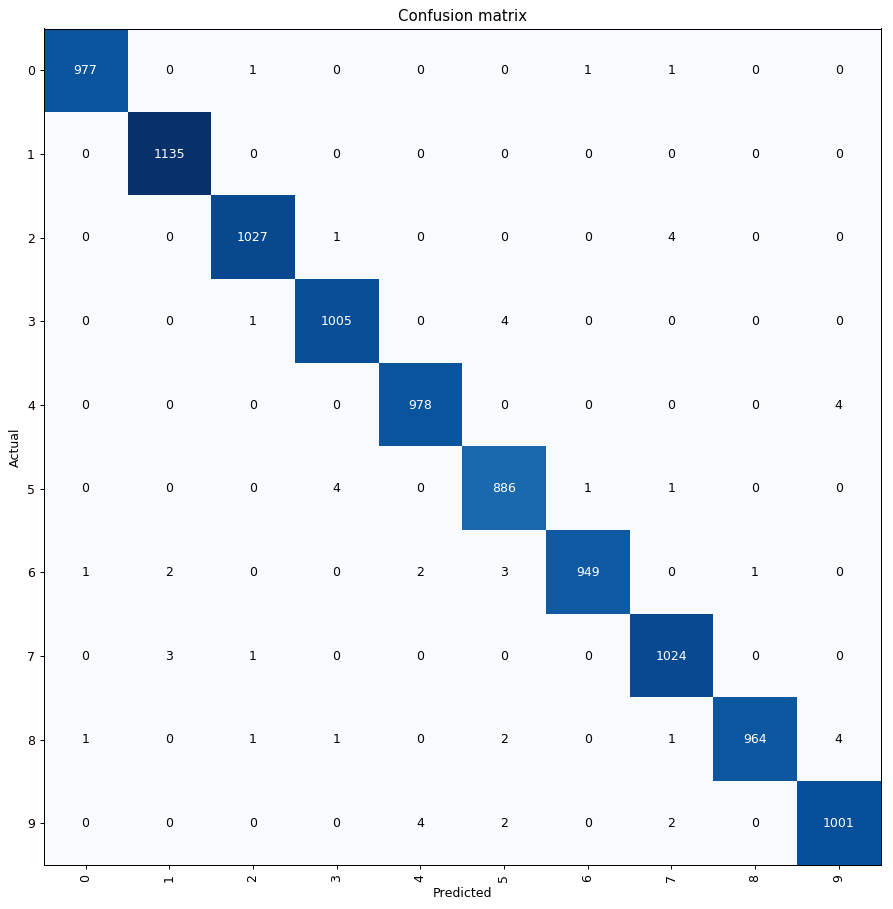

In [39]:
interp.plot_confusion_matrix(figsize=(10,10), dpi=90)

Even in the confusion matrix, we see that the result are far better this time. A lot more values are present across the diagonal. And the rest of the matrix contains mostly zeros.

In [40]:
interp.most_confused(min_val=3)

[('2', '7', 4),
 ('3', '5', 4),
 ('4', '9', 4),
 ('5', '3', 4),
 ('8', '9', 4),
 ('9', '4', 4),
 ('6', '5', 3),
 ('7', '1', 3)]

Even in most confused values, we see that there are far less values which are showing wrong results and the max count is just 4 which seems pretty good.

*We can definetly try to improve the model but at present the model seems pretty good with an accuracy of almost 99.5%. *

**The next step would be to either write some numbers or get a random data from somewhere else and make sure that we are not overfitting.**